# Описание проекта

Есть датасет с информации о жилье в калифорнии в 1990 году. Необходимо обучить модель линейной регрессии предсказывать медианную стоимость жилья. Первую модель необходимо обучить используя все признаки, вторую используя только количественные признаки. И сравнить их качесвто

# Информация о датасете

В колонках датасета содержатся следующие данные:
- longitude — широта;
- latitude — долгота;
- housing_median_age — медианный возраст жителей жилого массива;
- total_rooms — общее количество комнат в домах жилого массива;
- total_bedrooms — общее количество спален в домах жилого массива;
- population — количество человек, которые проживают в жилом массиве;
- households — количество домовладений в жилом массиве;
- median_income — медианный доход жителей жилого массива;
- median_house_value — медианная стоимость дома в жилом массиве;
- ocean_proximity — близость к океану.

# Запустим спарк сессию

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import corr


from pyspark.ml.feature import StringIndexer, VectorAssembler,StandardScaler 
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator
    
RANDOM_SEED = 2022


spark = SparkSession.builder.master("local[*]").getOrCreate()


25/08/18 21:41:39 WARN Utils: Your hostname, MacBook-Air-Urij.local resolves to a loopback address: 127.0.0.1; using 192.168.1.120 instead (on interface en0)
25/08/18 21:41:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/18 21:41:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Прочитаем данные

In [2]:
df = spark.read.csv('housing.csv', sep = ',', header = True,inferSchema=True)

In [3]:
df.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

# Обработка данных

In [4]:
df.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

In [5]:
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



Типы данных приведены верно 

In [6]:
df.count()

20640

In [7]:
df.distinct().count()

20640

Дубликаов нет

In [8]:
for col in df.columns:
    nans = df.select(col).where(df[col].isNull()).count()
    print(f'col:{col}, nans: {nans}')

col:longitude, nans: 0
col:latitude, nans: 0
col:housing_median_age, nans: 0
col:total_rooms, nans: 0
col:total_bedrooms, nans: 207
col:population, nans: 0
col:households, nans: 0
col:median_income, nans: 0
col:median_house_value, nans: 0
col:ocean_proximity, nans: 0


Есть пропуски в total_bedrooms - общее количество спален в домах жилого массива

In [9]:
df.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

Мы видим, что чем больше population и households, тем больше total_bedrooms в жилом массиве

In [10]:
df.select(corr('total_bedrooms','households')).show()

+--------------------------------+
|corr(total_bedrooms, households)|
+--------------------------------+
|              0.9797282708045709|
+--------------------------------+



Присутствует практически линейная зависимость total_bedrooms от households

In [11]:
df.select(F.avg(F.col('households')/F.col('total_bedrooms'))).show()

+----------------------------------+
|avg((households / total_bedrooms))|
+----------------------------------+
|                0.9417471793853955|
+----------------------------------+



Мы понимаем households и total_bedrooms соотносятся как 0.94

In [12]:
df = df.withColumn('total_bedrooms',F.when(F.col('total_bedrooms').isNull(),F.col('households')/0.94)\
                                 .otherwise(F.col('total_bedrooms')))

In [13]:
df.describe().show()

25/08/18 21:41:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|  count|              20640|            20640|             20640|             20640|             20640|             20640|            20640|             20640|             20640|          20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.9177727610096|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|           NULL|
| stddev|  2.0035317

Пропущенные значения заполнены.

# Корреляция признаков

Так как мы будем строить модель линейной регрессии, нужно исследовать сильно коррелируемые признаки, чтобы учесть коллинеарность в модели.

In [14]:
list1 = df.columns

In [15]:
columns = [i for i in list1 if i not in ('ocean_proximity','longitude','latitude')]

In [16]:
value_list = []
name_list = []
for column in columns:
    clear_columns = [i for i in list1 if i not in ('ocean_proximity','longitude','latitude',column)]
    for c in clear_columns:
        pd_df = df.select(corr(column,c)).toPandas()  
        
        name = column+'_vs_'+c
        value = pd_df[pd_df.columns[0]][0]
        
        value_list.append(value)
        name_list.append(name)
        
        
df_plot = pd.DataFrame({'name':name_list,
                        'value':value_list})

In [17]:
df_plot.query('value<-0.5 or value>0.5')

,name,value
7,total_rooms_vs_total_bedrooms,0.929856
8,total_rooms_vs_population,0.857126
9,total_rooms_vs_households,0.918484
13,total_bedrooms_vs_total_rooms,0.929856
14,total_bedrooms_vs_population,0.878063
15,total_bedrooms_vs_households,0.979920
19,population_vs_total_rooms,0.857126
20,population_vs_total_bedrooms,0.878063
21,population_vs_households,0.907222
25,households_vs_total_rooms,0.918484


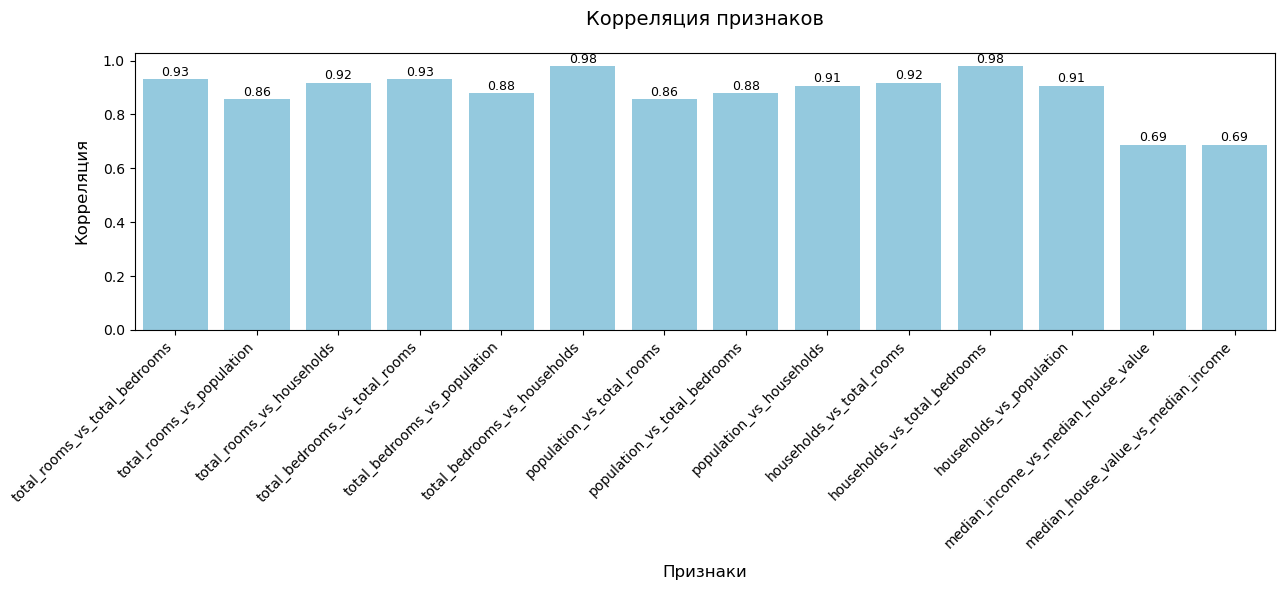

In [18]:
filtered_df = df_plot.query('value<-0.5 or value>0.5')
plt.figure(figsize=(13, 6))
ax = sns.barplot(x='name', y='value', data=filtered_df, color='skyblue')

plt.title('Корреляция признаков', fontsize=14, pad=20)
plt.xlabel('Признаки', fontsize=12, labelpad=10)
plt.ylabel('Корреляция', fontsize=12, labelpad=10)
plt.xticks(rotation=45, ha='right') 

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), 
                textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

Видим достаточно много коррелирующих между собой признаков. Поэтому в линейной регрессии будем использовать регуляризацию.

In [19]:
df.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [20]:
df_new = df.select(['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity'])

In [21]:
df_new.show(5)

+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|              52.0|     1627.0|         280.0|     565.0|     259.0|       3.8462|          342200.0|       NEAR BAY|
+------------------+-----------+--------------+-

In [22]:
numerical_cols=['housing_median_age','total_rooms','total_bedrooms','population','households','median_income']
categorical_cols = ['ocean_proximity']
target = 'median_house_value'

# Стандартизация количественных данных

Положим числовые признаки в вектор, чтобы затем заскейлить

In [23]:
numerical_assembler = VectorAssembler(inputCols = numerical_cols,outputCol = 'numerical_features')

df_new = numerical_assembler.transform(df_new)

In [24]:
df_new.show(5)

+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+--------------------+
|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|  numerical_features|
+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+--------------------+
|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|[41.0,880.0,129.0...|
|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|[21.0,7099.0,1106...|
|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|[52.0,1467.0,190....|
|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|[52.0,1274.0,235....|
|              52.0|

Стандартизируем вектор

In [25]:
standardScaler = StandardScaler(inputCol='numerical_features', outputCol='numerical_features_scaled')
standardScaler = standardScaler.fit(df_new)


df_new = standardScaler.transform(df_new)

In [26]:
df_new.show(5)

+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+--------------------+-------------------------+
|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|  numerical_features|numerical_features_scaled|
+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+--------------------+-------------------------+
|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|[41.0,880.0,129.0...|     [3.25770230160830...|
|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|[21.0,7099.0,1106...|     [1.66857922765303...|
|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|[52.0,1467.0,190....|     [4.13171999228370...|
|   

# Трансформация категориальных признаков

Сперва дадим числовое обозначение нашим признакам

In [27]:
categorical_col = 'ocean_proximity'

In [28]:
indexer = StringIndexer(inputCol= categorical_col, outputCol = categorical_col + '_idx')

ind = indexer.fit(df_new)

df_new = ind.transform(df_new)

In [29]:
df_new.toPandas().head(5)

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,numerical_features,numerical_features_scaled,ocean_proximity_idx
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,"[41.0, 880.0, 129.0, 322.0, 126.0, 8.3252]","[3.2577023016083064, 0.40337085073160667, 0.30...",3.0
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,"[21.0, 7099.0, 1106.0, 2401.0, 1138.0, 8.3014]","[1.668579227653035, 3.2540109878905406, 2.6253...",3.0
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,"[52.0, 1467.0, 190.0, 496.0, 177.0, 7.2574]","[4.131719992283705, 0.6724375432082579, 0.4510...",3.0
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,"[52.0, 1274.0, 235.0, 558.0, 219.0, 5.6431]","[4.131719992283705, 0.5839709816273487, 0.5578...",3.0
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,"[52.0, 1627.0, 280.0, 565.0, 259.0, 3.8462]","[4.131719992283705, 0.7457776978867319, 0.6646...",3.0


Теперь положим категориальный признак в вектор, методом OneHotEncoder, чтобы модель не подумала ранжировать их 

In [30]:
encoder = OneHotEncoder(inputCol = 'ocean_proximity_idx',outputCol='ocean_proximity_idx_encoder')
encoder = encoder.fit(df_new)
df_new = encoder.transform(df_new)

In [31]:
df_new.toPandas().head(5)

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,numerical_features,numerical_features_scaled,ocean_proximity_idx,ocean_proximity_idx_encoder
0,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,"[41.0, 880.0, 129.0, 322.0, 126.0, 8.3252]","[3.2577023016083064, 0.40337085073160667, 0.30...",3.0,"(0.0, 0.0, 0.0, 1.0)"
1,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,"[21.0, 7099.0, 1106.0, 2401.0, 1138.0, 8.3014]","[1.668579227653035, 3.2540109878905406, 2.6253...",3.0,"(0.0, 0.0, 0.0, 1.0)"
2,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,"[52.0, 1467.0, 190.0, 496.0, 177.0, 7.2574]","[4.131719992283705, 0.6724375432082579, 0.4510...",3.0,"(0.0, 0.0, 0.0, 1.0)"
3,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,"[52.0, 1274.0, 235.0, 558.0, 219.0, 5.6431]","[4.131719992283705, 0.5839709816273487, 0.5578...",3.0,"(0.0, 0.0, 0.0, 1.0)"
4,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,"[52.0, 1627.0, 280.0, 565.0, 259.0, 3.8462]","[4.131719992283705, 0.7457776978867319, 0.6646...",3.0,"(0.0, 0.0, 0.0, 1.0)"


In [32]:
df_new.select('ocean_proximity_idx').distinct().count()

5

# Обьеденение признаков в один вектор

In [33]:
df_new.columns

['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'numerical_features',
 'numerical_features_scaled',
 'ocean_proximity_idx',
 'ocean_proximity_idx_encoder']

In [34]:
assembler = VectorAssembler(inputCols = ['numerical_features_scaled','ocean_proximity_idx_encoder'],outputCol = 'assembler_features')

df_new = assembler.transform(df_new)

In [35]:
df_new.select('assembler_features').show(5)

+--------------------+
|  assembler_features|
+--------------------+
|[3.25770230160830...|
|[1.66857922765303...|
|[4.13171999228370...|
|[4.13171999228370...|
|[4.13171999228370...|
+--------------------+
only showing top 5 rows



# Разделение выборок

In [36]:
train_data, test_data = df_new.randomSplit([.8,.2], seed = RANDOM_SEED)

In [37]:
train_data.count()

16418

In [38]:
test_data.count()

4222

# Обучение модели

В рамках задачи будут две модели. Первая - со всеми признаками. Вторая - только с количественными.

## Все признаки

In [39]:
lr = LinearRegression(regParam=0.5, elasticNetParam=0.8, labelCol=target,featuresCol = 'assembler_features' )
#так как мы видели, что много признаков коррелируют нужно использовать эластичную регуляризаци/

In [40]:
model = lr.fit(train_data)

25/08/18 21:41:55 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [41]:
predictions = model.transform(test_data)

In [42]:
predictions.columns

['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity',
 'numerical_features',
 'numerical_features_scaled',
 'ocean_proximity_idx',
 'ocean_proximity_idx_encoder',
 'assembler_features',
 'prediction']

## Оценка качества модели 

In [43]:
rmse = RegressionEvaluator(predictionCol='prediction', labelCol='median_house_value', metricName='rmse').evaluate(predictions)

In [44]:
print(rmse)

69541.57204295803


In [45]:
mae = RegressionEvaluator(predictionCol='prediction', labelCol='median_house_value', metricName='mae').evaluate(predictions)

In [46]:
print(mae)

50758.75591509759


In [47]:
r2 = RegressionEvaluator(predictionCol='prediction', labelCol='median_house_value', metricName='r2').evaluate(predictions)

In [48]:
print(r2)

0.646582195595478


In [49]:
df_new.select('median_house_value').describe().show()

+-------+------------------+
|summary|median_house_value|
+-------+------------------+
|  count|             20640|
|   mean|206855.81690891474|
| stddev|115395.61587441359|
|    min|           14999.0|
|    max|          500001.0|
+-------+------------------+



C учетом того, что среднее в выборке 200 тысяч, ошибка в 50 тысяч кажется существенной. Но видя тандартное отклонение в 115 тысяч, можно сказать что 50 тысяч не настолько плохой результат, если бы мы предсказывали средним, прогноз получился бы хуже

# Модель номер 2 - только количественные признаки

In [54]:
train_data.toPandas().head(5)

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,numerical_features,numerical_features_scaled,ocean_proximity_idx,ocean_proximity_idx_encoder,assembler_features
0,1.0,6.0,2.0,8.0,2.0,1.6250,55000.0,INLAND,"[1.0, 6.0, 2.0, 8.0, 2.0, 1.625]","[0.07945615369776357, 0.002750255800442773, 0....",1.0,"(0.0, 1.0, 0.0, 0.0)","[0.07945615369776357, 0.002750255800442773, 0...."
1,1.0,83.0,15.0,32.0,15.0,4.8750,141700.0,INLAND,"[1.0, 83.0, 15.0, 32.0, 15.0, 4.875]","[0.07945615369776357, 0.038045205239458355, 0....",1.0,"(0.0, 1.0, 0.0, 0.0)","[0.07945615369776357, 0.038045205239458355, 0...."
2,1.0,2254.0,328.0,402.0,112.0,4.2500,189200.0,INLAND,"[1.0, 2254.0, 328.0, 402.0, 112.0, 4.25]","[0.07945615369776357, 1.0331794290330016, 0.77...",1.0,"(0.0, 1.0, 0.0, 0.0)","[0.07945615369776357, 1.0331794290330016, 0.77..."
3,2.0,96.0,18.0,30.0,16.0,5.3374,47500.0,INLAND,"[2.0, 96.0, 18.0, 30.0, 16.0, 5.3374]","[0.15891230739552714, 0.044004092807084366, 0....",1.0,"(0.0, 1.0, 0.0, 0.0)","[0.15891230739552714, 0.044004092807084366, 0...."
4,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,"[2.0, 158.0, 43.0, 94.0, 57.0, 2.5625]","[0.15891230739552714, 0.07242340274499301, 0.1...",3.0,"(0.0, 0.0, 0.0, 1.0)","[0.15891230739552714, 0.07242340274499301, 0.1..."


In [73]:
lr2 = LinearRegression(regParam=0.5, elasticNetParam=0.8, labelCol=target,featuresCol = 'numerical_features_scaled' )
#так как мы видели, что много признаков коррелируют нужно использовать эластичную регуляризаци/

In [74]:
model2 = lr2.fit(train_data)

In [75]:
predictions2 = model2.transform(test_data)

# Оценка качества модели 2

In [76]:
rmse = RegressionEvaluator(predictionCol='prediction', labelCol='median_house_value', metricName='rmse').evaluate(predictions2)

In [77]:
print(rmse)

75437.82054651006


In [78]:
mae = RegressionEvaluator(predictionCol='prediction', labelCol='median_house_value', metricName='mae').evaluate(predictions2)

In [79]:
print(mae)

56093.74408563228


In [80]:
r2 = RegressionEvaluator(predictionCol='prediction', labelCol='median_house_value', metricName='r2').evaluate(predictions2)

In [81]:
print(r2)

0.5841107621284105


Видим, что без использования категориальной метрики качество прогноза проседает.

# Вывод

Мы построили простую модель линейной регрессии которая предсказывает медианную стоимость жилья. При этом использование всех признаков, которые нам даны в датасете улучшают предсказательную способность модели, она лучше по всем метрикам rmse, mae и r2